In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import fetch_openml


In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255


In [3]:
digits = 10
examples = y.shape[0]

y = y.reshape(1, examples)

Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

m = 60000
m_test = X.shape[0] - m

X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:, :m], Y_new[:, m:]

shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((784, 60000), (784, 10000), (10, 60000), (10, 10000))

In [4]:
def show(image, label):
    plt.imshow(image.reshape(28, 28), cmap = matplotlib.cm.binary)
    plt.axis('off')
    plt.show()
    print(label)

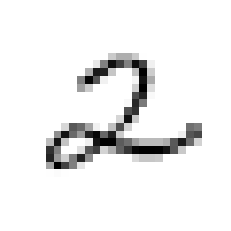

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
i = 12
show(X_train[:,i].reshape(1, -1), Y_train[:,i])

In [6]:
class NNImage(object):
    """Classifier for the classic MNIST handwritten numbers dataset.
    
    Instantiate an instance with desired hyperparameters:    
    model = NNImage(batch_size=32)
    
    X must be an array of flattened 28x28 pixel 8bit grayscale images.
    
    y must be an array of integer labels.
    
    Train model by calling model.fit(X, y)
    
    Call model.predict(X) to get a prediction on a new image.
    
    Call model.plot() to plot loss per epoch.
    
    :param epochs: int Number of training iterations Default = 2000
    :param batch_size: int Number of training examples per training iteration
        Default = None == full dataset is run per each trainint iteratin.
    :param learning_rate: float Step size to adjust weights and biases per iteration.
    :param n_hidden: int Number of nodes in hidden layer. Default = 128
    
    
    """
    def __init__(self, epochs=1000, batch_size=None, learning_rate=1, n_hidden=128):
        self.lr = learning_rate
        self.epochs = epochs
        self.m = None
        self.batch_size = batch_size
        self.losses = []
        
        # Initialize hidden layer.
        self.hidden_weight = np.random.randn(n_hidden, 784)
        self.hidden_bias = np.zeros((n_hidden, 1))
        
        # Initialize ouput layer.
        self.output_weight = np.random.randn(10, n_hidden)
        self.output_bias = np.zeros((10, 1))
        
    
    def sigmoid(self, x):
        """Sigmoid activation fuction"""
        
        return 1 / (1 + np.exp(-x))

    def loss(self, y, yhat):
        """Multiclass loss."""
        
        # Sum the log loss.
        loss_sum = np.sum(np.multiply(y, np.log(yhat)))
        # And average over all training examples.
        m = y.shape[1]
        return -(1 / m) * loss_sum
    
    def fit(self, X, y):
        """Train the model"""
        
        for i in range(1, self.epochs + 1):
            # Generate random subset if batch_size specified.
            if self.batch_size:
                X = np.random.permutation(X)[:,range(self.batch_size)]
                y = np.random.permutation(y)[:,range(self.batch_size)]
            
            # One training iteration.
            self.m = X.shape[1]
            p = self.predict(X)
            loss = self.backpass(X, y, p)
            
            # Print and record loss for every 100 iterations.
            if i % 100 == 0:
                self.losses.append(loss)
                print(f'Loss at epoch {i}: {loss}')
   
    def predict(self, X):
        """Forward pass of network."""
        
        # Apply  hidden layer's weights and bias to features.
        self.hidden_output = np.matmul(self.hidden_weight, X) + self.hidden_bias
        # Apply sigmoid activaton
        self.activated_hidden = self.sigmoid(self.hidden_output)
        
        # Apply output layer's weights and bias to hidden layer output.
        output_output = np.matmul(self.output_weight, self.activated_hidden) + self.output_bias
        # Apply softmax activation.
        activated_output = np.exp(output_output) / np.sum(np.exp(output_output), axis=0)

        return activated_output
    
    def backpass(self, X, y, out):
        """Backpropogation algorithm"""
        
        # TODO: Add optimizer.
        loss = self.loss(y, out)
        
        # Calculate error.
        delta_output = out - y
        # Calculate gradients for output layer weights and biases
        delta_output_weight = (1. / self.m) * np.matmul(delta_output, self.activated_hidden.T)
        delta_output_bias = (1. / self.m) * np.sum(delta_output, axis=1, keepdims=True)
        
        # Weighted sum of errors.
        delta_activation = np.matmul(self.output_weight.T, delta_output)
        # Apply weighted sum to derivative of sigmoid activation.
        delta_hidden = delta_activation * self.sigmoid(self.hidden_output) * (1 - self.sigmoid(self.hidden_output))
        
        # Caluculate gradients for output layer weights and bias
        delta_hidden_weight = (1. / self.m) * np.matmul(delta_hidden, X.T)
        delta_hidden_bias = (1. / self.m) * np.sum(delta_hidden, axis=1, keepdims=True)
        
        # Update weights and biases.
        self.output_weight -= self.lr * delta_output_weight
        self.output_bias -= self.lr * delta_output_bias

        self.hidden_weight -= self.lr * delta_hidden_weight
        self.hidden_bias -= self.lr * delta_hidden_bias
        
        # Return loss for plotting.
        return loss
    
    def plot(self):
        """Plot the loss per 100 epochs"""
        
        plt.figure(figsize=(10, 10))
        plt.title('Loss by epoch.')
        plt.xlabel('Epochs / 100')
        plt.ylabel('Cross Entropy')
        plt.plot(self.losses)
        plt.show()
        

In [12]:
nni = NNImage(epochs=1000, batch_size=None, learning_rate=1, n_hidden=64)


In [13]:
nni.fit(X_train, Y_train)

Loss at epoch 100: 0.7330853613949173
Loss at epoch 200: 0.5553923108052644
Loss at epoch 300: 0.4807410918818313
Loss at epoch 400: 0.4362435548556087
Loss at epoch 500: 0.4052312797323968
Loss at epoch 600: 0.38162988012052457
Loss at epoch 700: 0.3626548965686762
Loss at epoch 800: 0.3468297712792368
Loss at epoch 900: 0.3332681318817552
Loss at epoch 1000: 0.32140141279383966


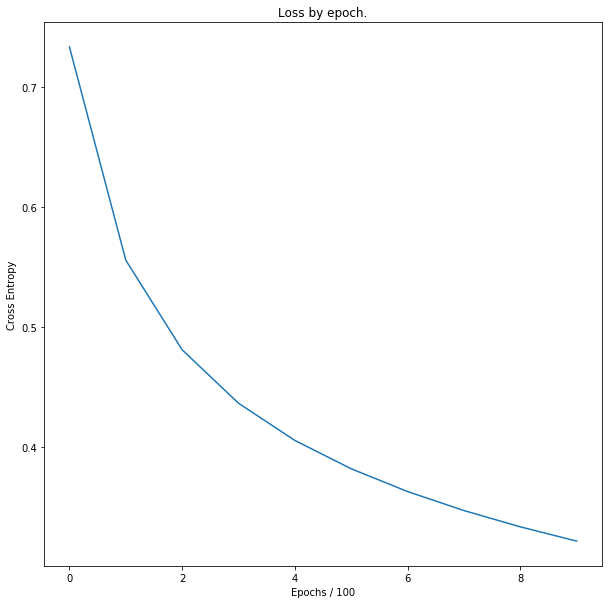

In [14]:
nni.plot()

In [15]:
def nice_confusion(y_true, y_pred):
    return sns.heatmap(confusion_matrix(y_true, y_pred),
                       annot=True,
                       fmt='d',
                       cmap='copper_r')


              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1009
           1       0.97      0.97      0.97      1140
           2       0.87      0.88      0.88      1021
           3       0.89      0.88      0.88      1025
           4       0.91      0.89      0.90      1011
           5       0.85      0.87      0.86       867
           6       0.92      0.92      0.92       965
           7       0.90      0.92      0.91      1002
           8       0.86      0.87      0.86       964
           9       0.86      0.87      0.87       996

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



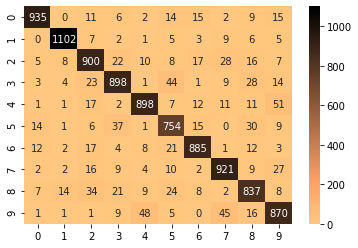

In [16]:
predictions = np.argmax(nni.predict(X_test), axis=0)
labels = np.argmax(Y_test, axis=0)
nice_confusion(predictions, labels)
print(classification_report(predictions, labels))